https://www.youtube.com/watch?v=n9_XyCGr-MI

In [1]:
import torch
import os
import cv2
import matplotlib.pyplot as plt
from model import *
from loss import *
from dataset import *
from train import *
from utils import *
from PIL import Image
from skimage import io, transform
import torchvision.transforms as transforms

In [2]:
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 16 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0
LOAD_MODEL_FILE = "overfit.pth.tar"
model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = YoloLoss()

load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

=> Loading checkpoint


In [3]:
transform = transforms.Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])

In [4]:
train_dataset = VOCDataset("data\\100examples.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR)

In [5]:
image, label_matrix = train_dataset[0]

In [7]:
image.shape

torch.Size([3, 448, 448])

In [8]:
model.eval()

Yolov1(
  (darknet): Sequential(
    (0): CNNBlock(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): CNNBlock(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): CNNBlock(
      (conv): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
  

In [9]:
with torch.no_grad():
    predictions = model(image.unsqueeze(0).float().to(DEVICE))

In [10]:
predictions.shape

torch.Size([1, 1470])

In [11]:
bboxes = cellboxes_to_boxes(predictions)

In [12]:
nms_boxes = non_max_suppression(bboxes[0], iou_threshold=0.5, threshold=0.4, box_format="midpoint",)

In [13]:
len(nms_boxes)

3

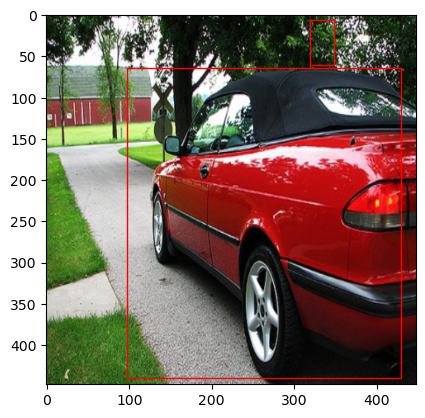

In [18]:
plot_image(image.permute(1,2,0).to("cpu"), nms_boxes)